In [1]:
import numpy as np
import pprint as pp
from matplotlib import pyplot as plt
import shutil
import os
import copy
from typing import List, Tuple, Dict, Any
from IPython.display import clear_output
import time
from tqdm.notebook import tqdm
import random

### Utils

In [2]:
def read_data_file(file_name: str) -> Dict[Any, Any]:
    tsp_data = {}
    with open(FILENAME, 'r') as file:
        for line in file:
            if line.startswith('EOF'):
                break
            if line.startswith('DIMENSION'):
                tsp_data['DIMENSION'] = int(line.split()[1])
            parts = line.split()
            if parts[0].isdigit():
                node, x, y = map(int, parts)
                tsp_data[node] = (x, y)

    return tsp_data

def calculate_distance_matrix(tsp_data: Dict[Any, Any]) -> np.ndarray:
    N = tsp_data['DIMENSION']
    tsp_data.pop('DIMENSION')

    distance_matrix = [[0 for _ in range(N + 1)] for _ in range(N + 1)]
    for node in tsp_data:
        x1, y1 = tsp_data[node]
        for other_node in tsp_data:
            if node == other_node:
                continue
            else:
                x2, y2 = tsp_data[other_node]
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                distance_matrix[node][other_node] = distance
                distance_matrix[other_node][node] = distance
    return np.array(distance_matrix)

def print_distance_matrix(distance_matrix: np.ndarray):
    print(distance_matrix)

In [3]:
def plot_cities(data: Dict[Any, Any]) -> None:
    x = []
    y = []
    for city in data:
        x.append(data[city][0])
        y.append(data[city][1])
    plt.scatter(x, y)
    plt.show()


def plot_cycles(cycle1: List, cycle2: List, tsp_data: Dict[Any, Any], file_name) -> None:
    plt.figure(figsize=(8, 6))

    for city in cycle1:
        plt.scatter(tsp_data[city][0], tsp_data[city][1], color='red', s=30)
        plt.text(tsp_data[city][0], tsp_data[city][1], str(city), fontsize=8, ha='left', va='bottom')

    cycle1_x = [tsp_data[city][0] for city in cycle1]
    cycle1_y = [tsp_data[city][1] for city in cycle1]
    cycle1_x.append(cycle1_x[0])
    cycle1_y.append(cycle1_y[0])
    plt.plot(cycle1_x, cycle1_y, linestyle='-', color='blue', label='Cycle 1')

    for city in cycle2:
        plt.scatter(tsp_data[city][0], tsp_data[city][1], color='red', s=30)
        plt.text(tsp_data[city][0], tsp_data[city][1], str(city), fontsize=8, ha='left', va='bottom')

    cycle2_x = [tsp_data[city][0] for city in cycle2]
    cycle2_y = [tsp_data[city][1] for city in cycle2]
    cycle2_x.append(cycle2_x[0])
    cycle2_y.append(cycle2_y[0])
    plt.plot(cycle2_x, cycle2_y, linestyle='-', color='green', label='Cycle 2')

    plt.title('Visualization of Cycles')
    plt.xlabel('X-coordinate')
    plt.ylabel('Y-coordinate')
    plt.grid(True)
    plt.legend()
    plt.savefig(file_name)
    plt.show()


In [4]:
def get_nodes(tsp_data: Dict[Any, Any]) -> np.ndarray:
    nodes = []
    for node in tsp_data:
        if node != 'DIMENSION':
            nodes.append(node)
    return np.array(nodes)

In [5]:
def swap_nodes_between_cycles(cycle1: List, cycle2: List, a_index: int, b_index: int) -> Tuple[np.ndarray, np.ndarray]:
    # cycle1 = copy.deepcopy(cycle1)
    # cycle2 = copy.deepcopy(cycle2)

    tmp = cycle2[b_index]
    cycle2[b_index] = cycle1[a_index]
    cycle1[a_index] = tmp

    return cycle1, cycle2


def swap_edge_within_cycle(cycle: List, a_index: int, b_index: int) -> List:
    # cycle = copy.deepcopy(cycle)
    
    b_index = (b_index + 1) % (len(cycle) + 1)
    if a_index > b_index:
        a_index, b_index = b_index, a_index
    cycle[a_index:b_index] = cycle[a_index:b_index][::-1]
    return cycle

In [6]:
SWAP_NODES_BETWEEN = 2
SWAP_EDGES_WITHIN_CYCLE_1 = 0
SWAP_EDGES_WITHIN_CYCLE_2 = 1

def generate_moves(cycle: List):

    moves = []
    N = len(cycle)

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_1, (j, k)))

    # generate edges
    for i in range(2, N-1):
        for j in range(N):
            k = (j + i) % (N)
            if j < k:
                moves.append((SWAP_EDGES_WITHIN_CYCLE_2, (j, k)))

    # generate nodes
    for i in range(N):
        for j in range(N):
                moves.append((SWAP_NODES_BETWEEN, (i, j)))
    
    # shuffle moves
    np.random.shuffle(moves)
    return moves

In [7]:
def apply_move(move: Tuple[int, Tuple[int, int]], cycle1: List, cycle2: List) -> Tuple[List, List]:
    move_type, (a, b) = move
    
    if move_type == SWAP_NODES_BETWEEN:
        cycle1, cycle2 = swap_nodes_between_cycles(cycle1, cycle2, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_1:
        cycle1 = swap_edge_within_cycle(cycle1, a, b)

    elif move_type == SWAP_EDGES_WITHIN_CYCLE_2:
        cycle2 = swap_edge_within_cycle(cycle2, a, b)

    return cycle1, cycle2

In [8]:
def calculate_cycles_length(cycle1: List, cycle2: List, distance_matrix: np.ndarray) -> float:
    c = [cycle1, cycle2]
    total_length = 0
    for cycle in c:
        length = 0
        for i in range(len(cycle)):
            length += distance_matrix[cycle[i-1]][cycle[i]]
        total_length += length

    return total_length

### Random TSP Algorithm

In [9]:
def random_cycle(nodes) -> Tuple[np.ndarray, np.ndarray]:
    nodes = copy.deepcopy(nodes)
    np.random.shuffle(nodes)
    half = len(nodes) // 2
    cycle1 = np.array(nodes[:half])
    cycle2 = np.array(nodes[half:])
    
    return cycle1, cycle2

### Candidate Moves Algorithm

In [10]:
def compute_k_closest_neighbours(distance, k):
    dist = distance[1:, 1:]
    closest = np.argpartition(dist, k+1, axis=1)[:, :k+1] + 1
    zeros = np.zeros(len(closest[0]), dtype=np.uint16)
    return np.concatenate(([zeros], closest))

def find_city(cycle1, cycle2, node):
    out = np.where(cycle1 == node)[0]
    if len(out) == 1:
        return (True, out[0])
    else:
        return (False, np.where(cycle2 == node)[0][0])

def candidate_moves_algorithm(cycle1, cycle2, distance, data, k=10):
    closest = compute_k_closest_neighbours(distance, k)
    num_cities = len(get_nodes(data))
    iter = 0

    while True:
        best_move = None
        best_delta = 0

        for i in range(1, num_cities+1):
            for j in closest[i]:
                if i==j:
                    continue
                i_in_cycle1, pos_i = find_city(cycle1, cycle2, i)
                j_in_cycle1, pos_j = find_city(cycle1, cycle2, j)

                distance_before_succ = 0
                distance_after_succ = 0
                distance_after_pred = 0
                distance_before_pred = 0

                if (i_in_cycle1 and j_in_cycle1):
                    pos_i_succ = (pos_i+1)%len(cycle1)
                    pos_j_succ = (pos_j+1)%len(cycle1)

                    pos_i_pred = (pos_i-1)%len(cycle1)
                    pos_j_pred = (pos_j-1)%len(cycle1)

                    distance_before_succ = distance[i][cycle1[pos_i_succ]] + distance[j][cycle1[pos_j_succ]] # wariant 1
                    distance_after_succ = distance[i][j] + distance[cycle1[pos_i_succ]][cycle1[pos_j_succ]]

                    distance_before_pred = distance[i][cycle1[pos_i_pred]] + distance[j][cycle1[pos_j_pred]] # wariant 2
                    distance_after_pred = distance[i][j] + distance[cycle1[pos_i_pred]][cycle1[pos_j_pred]]

                elif (i_in_cycle1 is False and j_in_cycle1 is False):
                    pos_i_succ = (pos_i+1)%len(cycle2)
                    pos_j_succ = (pos_j+1)%len(cycle2)

                    pos_i_pred = (pos_i-1)%len(cycle2)
                    pos_j_pred = (pos_j-1)%len(cycle2)

                    distance_before_succ = distance[i][cycle2[pos_i_succ]] + distance[j][cycle2[pos_j_succ]]
                    distance_after_succ = distance[i][j] + distance[cycle2[pos_i_succ]][cycle2[pos_j_succ]]

                    distance_before_pred = distance[i][cycle2[pos_i_pred]] + distance[j][cycle2[pos_j_pred]]
                    distance_after_pred = distance[i][j] + distance[cycle2[pos_i_pred]][cycle2[pos_j_pred]]


                delta_succ = distance_after_succ - distance_before_succ
                delta_pred = distance_after_pred - distance_before_pred
                
                delta = min(delta_pred, delta_succ)
                which_delta = np.argmin([delta_succ, delta_pred])

                if best_delta > delta:
                    best_delta = delta
                    
                    if which_delta == 0:
                        pos = (pos_i_succ, pos_j)
                    elif which_delta == 1:
                        pos = (pos_i, pos_j_pred)
                        
                    if (i_in_cycle1 and j_in_cycle1):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_1, pos)
                    elif (i_in_cycle1 is False and j_in_cycle1 is False):
                        best_move = (SWAP_EDGES_WITHIN_CYCLE_2, pos)
                        
        if best_move is None:
            break

        cycle1, cycle2 = apply_move(best_move, cycle1, cycle2)
        if VISUALIZE:
            clear_output(wait=True)
            plot_cycles(cycle1, cycle2, data)
        iter += 1
    
    return cycle1, cycle2

### Extended Local Search

In [11]:
def MSLS(distance_matrix, data, n_iter=100):
    start_time = time.time()
    best_cycle_1 = None
    best_cycle_2 = None
    best_length = np.inf

    for _ in tqdm(range(n_iter)):
        cycle1, cycle2 = random_cycle(get_nodes(data))
        cycle1, cycle2 = candidate_moves_algorithm(cycle1, cycle2, distance_matrix, data)
        length = calculate_cycles_length(cycle1, cycle2, distance_matrix)
        
        if length < best_length:
            best_cycle_1 = cycle1
            best_cycle_2 = cycle2
            best_length = length
    stop_time = time.time()
    total_time = stop_time - start_time
    return best_cycle_1, best_cycle_2, total_time

In [12]:
def little_perturbation(cycle1, cycle2):
    for cycle in [cycle1, cycle2]:
        a = np.random.choice(cycle, 2, replace=False)
        a_idx_a = np.where(cycle==a[0])
        a_idx_b = np.where(cycle==a[1])
        
        tmp = cycle[a_idx_a]
        cycle[a_idx_a] = cycle[a_idx_b]
        cycle[a_idx_b] = tmp
    
    a = np.random.choice(cycle1, 1)
    a_idx = np.where(cycle1==a)
    
    b = np.random.choice(cycle2, 1)
    b_idx = np.where(cycle2==b)

    tmp = cycle1[a_idx]
    cycle1[a_idx] = cycle2[b_idx]
    cycle2[b_idx] = tmp

    return cycle1, cycle2

In [13]:
def ILS1(distance_matrix, data, time_MSLS):
    best_cycle_1, best_cycle_2 = random_cycle(get_nodes(data))
    best_cycle_1, best_cycle_2 = candidate_moves_algorithm(best_cycle_1, best_cycle_2, distance_matrix, data)
    best_length = calculate_cycles_length(best_cycle_1, best_cycle_2, distance_matrix)

    time_elapsed = 0

    while time_elapsed <= time_MSLS:
        start_time = time.time()
        cycle1, cycle2 = little_perturbation(best_cycle_1, best_cycle_2)
        cycle1, cycle2 = candidate_moves_algorithm(cycle1, cycle2, distance_matrix, data)
        length = calculate_cycles_length(cycle1, cycle2, distance_matrix)
        if length < best_length:
            best_length = length
            best_cycle_1 = cycle1
            best_cycle_2 = cycle2
        stop_time = time.time()
        time_elapsed += (stop_time - start_time)
    
    return best_cycle_1, best_cycle_2

In [14]:
def severe_perturbation(cycle1, cycle2, distance_matrix):
    original_size_cycle1 = len(cycle1)
    original_size_cycle2 = len(cycle2)
    # Destroy
    random1 = list(np.random.choice(cycle1, int(len(cycle1)*0.3), replace=False))
    cycle1 = list(np.setdiff1d(cycle1, random1, assume_unique=True))

    random2 = list(np.random.choice(cycle2, int(len(cycle2)*0.3), replace=False))
    cycle2 = list(np.setdiff1d(cycle2, random2, assume_unique=True))

    # Repair
    cities = random1 + random2

    while len(cycle1) < original_size_cycle1:
        current_city = cycle1[-1]
        nearest_city = min([(city, distance_matrix[current_city][city]) for city in cities], key=lambda x: x[1])[0]
        cycle1.append(nearest_city)
        cities.remove(nearest_city)

    while len(cycle2) < original_size_cycle2:
        current_city = cycle2[-1]
        nearest_city = min([(city, distance_matrix[current_city][city]) for city in cities], key=lambda x: x[1])[0]
        cycle2.append(nearest_city)
        cities.remove(nearest_city)
    
    return np.array(cycle1), np.array(cycle2)

In [15]:
def ILS2(distance_matrix, data, time_MSLS):
    best_cycle_1, best_cycle_2 = random_cycle(get_nodes(data))
    best_cycle_1, best_cycle_2 = candidate_moves_algorithm(best_cycle_1, best_cycle_2, distance_matrix, data)
    best_length = calculate_cycles_length(best_cycle_1, best_cycle_2, distance_matrix)

    time_elapsed = 0

    while time_elapsed <= time_MSLS:
        start_time = time.time()
        cycle1, cycle2 = severe_perturbation(best_cycle_1, best_cycle_2, distance_matrix)
        cycle1, cycle2 = candidate_moves_algorithm(cycle1, cycle2, distance_matrix, data)
        length = calculate_cycles_length(cycle1, cycle2, distance_matrix)
        if length < best_length:
            best_length = length
            best_cycle_1 = cycle1
            best_cycle_2 = cycle2
        stop_time = time.time()
        time_elapsed += (stop_time - start_time)
    
    return best_cycle_1, best_cycle_2

### Run

In [16]:
FILENAME = 'kroA200.tsp'
VISUALIZE = False
num_of_runs = 3

In [17]:
data = read_data_file(FILENAME)
distance_matrix = calculate_distance_matrix(data)

In [18]:
times = []
lengths = []
cycles = []

for _ in range(num_of_runs):
    cycle1_msls, cycle2_msls, time_elapsed = MSLS(distance_matrix, data, 100)
    msls_length = calculate_cycles_length(cycle1_msls, cycle2_msls, distance_matrix)

    start_time = time.time()
    cycle1_ils1, cycle2_ils1 = ILS1(distance_matrix, data, time_elapsed)
    stop_time = time.time()
    time_ILS1 = stop_time - start_time
    ils1_length = calculate_cycles_length(cycle1_ils1, cycle2_ils1, distance_matrix)

    start_time = time.time()
    cycle1_ils2, cycle2_ils2 = ILS2(distance_matrix, data, time_elapsed)
    stop_time = time.time()
    time_ILS2 = stop_time - start_time
    ils2_length = calculate_cycles_length(cycle1_ils2, cycle2_ils2, distance_matrix)

    times.append((time_elapsed, time_ILS1, time_ILS2))
    lengths.append((msls_length, ils1_length, ils2_length))
    cycles.append(((cycle1_msls, cycle2_msls), (cycle1_ils1, cycle2_ils1), (cycle1_ils2, cycle2_ils2)))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
times = np.array(times)
lengths = np.array(lengths)

In [20]:
lengths

array([[44552.21028045, 48005.20960413, 39236.82028914],
       [44552.93535789, 47933.07225964, 31617.22768351],
       [43440.07415997, 50472.01483565, 31920.3947746 ]])

In [21]:
np.mean(times, axis=0)

array([595.41769266, 601.72740364, 602.16991234])

In [22]:
np.mean(lengths, axis=0)

array([44181.73993277, 48803.43223314, 34258.14758242])

In [23]:
best = np.argmin(lengths, axis=0)

In [24]:
best_msls = cycles[best[0]][0]
best_isl1 = cycles[best[1]][1]
best_isl2 = cycles[best[2]][2]

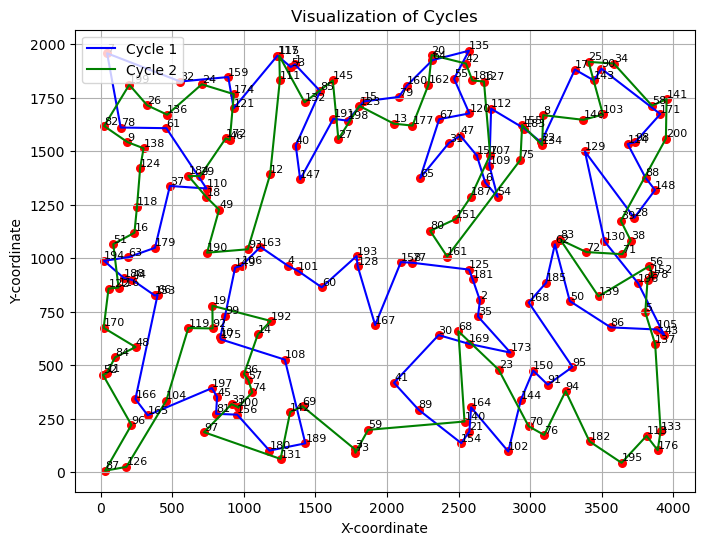

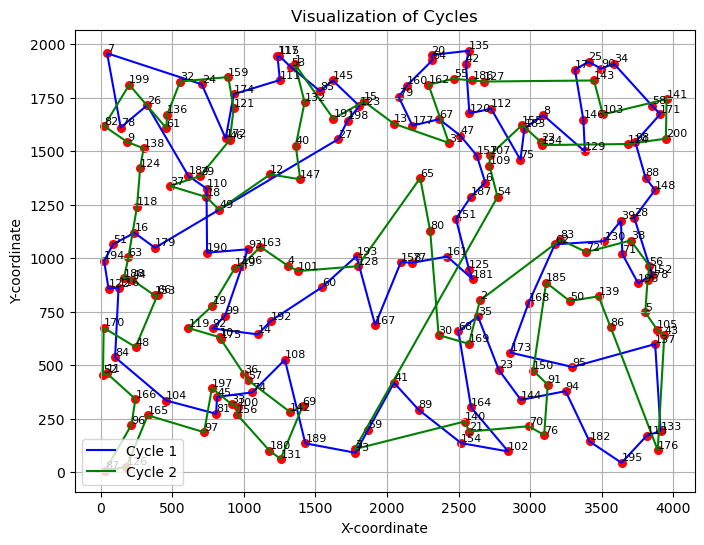

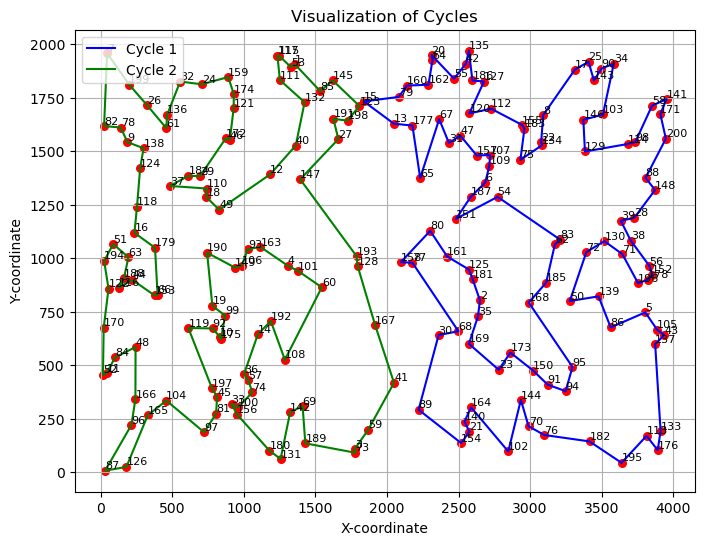

In [26]:
plot_cycles(best_msls[0], best_msls[1], data, "msls_kroa200.png")
plot_cycles(best_isl1[0], best_isl1[1], data, "isl1_kroa200.png")
plot_cycles(best_isl2[0], best_isl2[1], data, "isl2_kroa200.png")

In [27]:
times

array([[593.97663903, 600.31801486, 600.03377891],
       [596.17580795, 602.25394988, 603.8322351 ],
       [596.100631  , 602.61024618, 602.64372301]])